In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import PIL
from PIL import Image, ImageFont, ImageDraw
import random
import time
import cv2

%matplotlib inline

print(sys.executable)
print(sys.version)


/Users/education/anaconda/envs/abm/bin/python
3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


In [2]:
# EXAMPLE: create a grid and randomly populate with white, black or empty lots
grid = np.zeros((100,100))
brooklyn = np.random.choice(a=['B', 'W', 'E'], size=(30,10), p=[.40, .50, .10])

print('black count:', (brooklyn == 'B').sum())
print('white count:', (brooklyn == 'W').sum())
print('empty count:', (brooklyn == 'E').sum())

brooklyn

black count: 107
white count: 166
empty count: 27


array([['W', 'B', 'W', 'W', 'B', 'E', 'W', 'W', 'W', 'W'],
       ['B', 'B', 'W', 'W', 'B', 'W', 'B', 'W', 'W', 'W'],
       ['W', 'B', 'B', 'B', 'W', 'E', 'W', 'B', 'E', 'B'],
       ['W', 'W', 'B', 'B', 'B', 'B', 'B', 'E', 'W', 'B'],
       ['B', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'W'],
       ['W', 'W', 'W', 'W', 'E', 'W', 'E', 'W', 'W', 'B'],
       ['B', 'B', 'W', 'W', 'B', 'W', 'W', 'W', 'W', 'W'],
       ['B', 'B', 'B', 'W', 'W', 'W', 'W', 'B', 'W', 'B'],
       ['W', 'W', 'W', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
       ['W', 'W', 'W', 'W', 'W', 'E', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'B', 'W', 'W', 'W', 'W', 'W', 'B', 'E'],
       ['B', 'B', 'B', 'B', 'W', 'B', 'E', 'B', 'E', 'W'],
       ['B', 'W', 'B', 'B', 'B', 'W', 'B', 'W', 'W', 'W'],
       ['W', 'W', 'B', 'W', 'B', 'B', 'B', 'W', 'B', 'W'],
       ['W', 'W', 'W', 'B', 'B', 'E', 'B', 'B', 'B', 'B'],
       ['B', 'B', 'B', 'B', 'B', 'W', 'W', 'B', 'B', 'W'],
       ['W', 'B', 'W', 'W', 'B', 'E', 'B', 'B', 'B', 'B'

In [27]:


def wrap(x: tuple, rows: int, cols: int) -> tuple:

    '''
    wrap an x coordinate to a new position in a 2D grid. 

    Example: in a 4x4 grid, if an agent at (3,4) moves two down and two right, then the nex
    position should wrap around to (1,2)
    '''

    return (x[0] % rows, x[1] % cols )

def neighbors(x: tuple, grid: np.array, radius=1) -> list:

    '''
    get the neighbors of x within a given radius. x is the position coordinates and the function
    returns a list of position coordinates for the neighbors
    '''

    r,c = x[0], x[1]
    row_count = grid.shape[0]
    col_count = grid.shape[1]

    assert r>=0 and r<=row_count, 'error: invalid x position (row) in given grid'
    assert c>=0 and c<=col_count, 'error: invalid x position (column) in given grid'
    
    # iterate through neighbors within the neighborhood radius and collect a list
    res = []
    for i in range(r-radius, r+radius+1):
        for j in range(c-radius, c+radius+1):
            res.append( wrap(x=(i,j), rows=row_count, cols=col_count))
    
    # remove the original datapoint from the returned list
    res.remove(x)

    return res

def similarity(x_value, grid: np.array, neighbors: list) -> float:
    '''
    iterate through neighbors and define the percentage that are compatible with the subject
    '''

    neighbor_values = [get_value(n, grid) for n in neighbors]
    return (np.array(neighbor_values) == x_value).mean()


def get_value(x: tuple, grid: np.array):
    return grid[x[0], x[1]]

def find_values(grid: np.array, val) -> list:
    '''
    find the x coordinates in a grid that have the specified value
    '''
    found_locations = np.where(grid == val)
    return list(zip(found_locations[0], found_locations[1]))

def swap(grid: np.array, source: tuple, dest: tuple) -> np.array:

    ''' swap the values for two positions'''

    source_value = get_value(x=source, grid=grid)
    dest_value = get_value(x=dest, grid=grid)

    # swap
    grid[dest[0], dest[1]] = source_value
    grid[source[0], source[1]] = dest_value

    return grid

def get_all_spaces(grid):

    all_spaces = [(i,j) for j in range(grid.shape[1]) for i in range(grid.shape[0])]

    return all_spaces

def calc_avg_similarity(grid):

    system = []
    all_spaces = get_all_spaces(grid=grid)

    for agent in all_spaces:
        if get_value(x=agent, grid=grid) != 'E':
    
            _neighbors = neighbors(x=agent, grid=grid, radius=radius)
            _similarity = similarity(x_value=get_value(x=agent, grid=grid), grid=grid, neighbors=_neighbors)
            system.append(_similarity)

    return system

def simulate(grid, radius, cutpoint, num_iterations=50, verbose=0):

    # save the environment at each iteration
    simulations = []
    simulations.append(grid.copy())
    
    all_spaces = get_all_spaces(grid=grid)
    system = calc_avg_similarity(grid=grid)
    
    # save the average similarity across all households at each time period
    avg_similarities = []
    avg_similarities.append(np.array(system).mean())

    # save the number of households that are not content at each time period
    discontent_counts = []

    if not verbose is False:
        print('starting systemic similarity: {:.3f}'.format(np.array(system).mean()))

    start = time.time()
    
    for _ in range(num_iterations):

        # 1. get available empty spaces
        free_spaces = find_values(grid=grid, val='E')

        # randomly shuffle the available spaces
        random.shuffle(free_spaces)

        # 2. get agents that want to move
        wants_to_move = []
        for agent in all_spaces:
            if get_value(x=agent, grid=grid) != 'E':
                
                _neighbors = neighbors(x=agent, grid=grid, radius=radius)
                _similarity = similarity(x_value=get_value(x=agent, grid=grid), grid=grid, neighbors=_neighbors)

                if _similarity < cutpoint:
                    wants_to_move.append(agent)

        # randomly shuffle the agents that want to move 
        random.shuffle(wants_to_move)

        wants_to_move_count = len(wants_to_move)
        discontent_counts.append(wants_to_move_count)

        #if verbose == 2:
        #    print('{} agents want to move'.format(len(wants_to_move)))

        # try to move each agent that is unhappy
        for agent in wants_to_move:

            # if there are free spaces still available (not including spaces that became free because someone
            # moved in this period)
            if len(free_spaces) > 0:

                _free_space = free_spaces.pop()
                grid = swap(grid=grid, source=agent, dest=_free_space)


        # print avg similarity across the entire system
        system = calc_avg_similarity(grid=grid)
     
        if verbose == 0:
            pass
        elif verbose == 1:
            print('\r--iteration {}: systemic similarity: {:.3f}'.format(_, np.array(system).mean()), end="")
        elif verbose == 2:
            print('--iteration {}: systemic similarity: {:.3f}'.format(_, np.array(system).mean()) )           

        # save the environment and average similarity at the end of this iteration
        simulations.append(grid.copy())
        avg_similarities.append(np.array(system).mean())

    if verbose:
        print()
        print('done in {}s'.format(time.time() - start))       
    return np.array(system).mean(), simulations, avg_similarities, discontent_counts

def convert_to_numpy_image(grid: np.array, conversion_map: dict ) -> np.array:
        
    ''' 
    convert from a numpy array of ['B', 'W', 'E'] elements into a 
    numpy array that indicates pixels and colors
    '''

    w=grid.shape[0]
    h=grid.shape[1]
    
    img = np.zeros((w,h,3), dtype=np.uint8)
    for key in conversion_map.keys():
        
        # find 'B' elements in the grid (or 'W' or 'E')
        mask = grid == key

        # transform from 'B' to some rgb color (eg [38,131,131])
        img[mask] = conversion_map[key]

    # swap width and height
    img = np.reshape(img, (h,w,3))

    return img

def convert_pixels_to_squares(img: np.array, square_size: int) -> np.array:

    '''
    enlarge an image and convert from each pixel representing a household
    to a square (nxn pixels) representing a household. 
    '''

    # resize the original plot
    width = img.shape[1]
    height = img.shape[0]

    big_img = cv2.resize(img, dsize=(img.shape[1] * square_size, img.shape[0] * square_size), interpolation=cv2.INTER_NEAREST)

    # add a 2 pixel black border around each square
    for i in range(width):
        
        i *= square_size

        big_img[i-2:i,:] = [0,0,0]
        big_img[:,i-2:i] = [0,0,0]
    
    return big_img

def add_white_space(img: np.array, height: int) -> np.array:

    '''
    add a band of white space to the bottom of an image 
    (increase the size of the image)
    '''

    # create a numpy array to represent a white region
    h,w,d = img.shape
    new_rows = np.full((height, w, 3), fill_value=[255,250,250], dtype=np.uint8)
    
    # append the white region to the bottom of the original image array
    new_img = np.vstack([img, new_rows])

    return new_img

def add_text(img: np.array, text: str, text_position: tuple) -> np.array :

    '''
    '''

    title_font = ImageFont.truetype('RobotoCondensed-Light.ttf', 35)

    temp = Image.fromarray(img, 'RGB')
    ImageDraw.Draw(temp).text(text_position,  # Coordinates
    text,  # Text
    (38, 131, 131),  # Color
    font=title_font)

    return np.array(temp)

def build_image(grid: np.array, conversion_map: dict, square_size: int, white_space_height: int, text: str, text_position: tuple):

    temp = convert_to_numpy_image(grid=grid, conversion_map=conversion_map)
    temp = convert_pixels_to_squares(img=temp, square_size=square_size)
    temp = add_white_space(img=temp, height=white_space_height)
    temp = add_text(img=temp, text=text, text_position=text_position)

    return temp


# MAIN ANALYSIS: SIMULATION

* Run simulations for different levels of the in-group preference
* at each preference level, run the simulation multiple times and collect the average outcome


working on 0.05
working on 0.1
working on 0.15
working on 0.2
working on 0.25
working on 0.3
working on 0.35
working on 0.4
working on 0.45
working on 0.5
working on 0.55
working on 0.6
working on 0.65
working on 0.7


<AxesSubplot:xlabel='cut'>

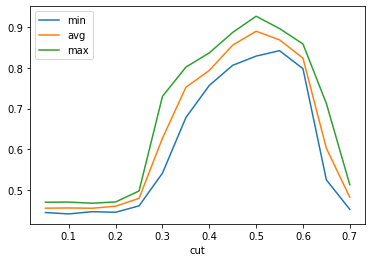

In [32]:

# PART 0: DEFINE SIMULATION PARAMETERS
radius = 2
cutpoint = 0.35

# PART 1: CREATE A GRID AND RANDOMLY ASSIGN HOUSEHOLDS
# init a random distribution of B, W, Es across a 2D grid
brooklyn = np.random.choice(a=['B', 'W', 'E'], size=(50,40), p=[.40, .50, .10])
all_spaces = [(i,j) for j in range(40) for i in range(50)]
np.random.seed(314159)

# number of times to run the simulation for each preference level
# (this is used to smooth the results because any single simulation could randomly deviate from its expected outcome)
num_simulations = 25

all_results = []
all_similarities_over_time = pd.DataFrame()
all_discontents_over_time = pd.DataFrame()

# iterate through different similarity preference levels
# try 25 different preference levels from 10% to 60%
#for cut in np.linspace(0.01, 0.6, 10):
for cut in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]:
    print('working on {}'.format(cut))

    end_similarities = []
    ts_similarities = []
    ts_discontents = []
    

    # run multiple simulations so we get smoothed results for each similarity preference level
    for _ in range(num_simulations):
        
        # initialize
        brooklyn = np.random.choice(a=['B', 'W', 'E'], size=(50,40), p=[.40, .50, .10])
        
        end_avg_similarity, simulations, similarities, discontents = simulate(grid=brooklyn, radius=radius, cutpoint=cut, num_iterations=100, verbose=False)
        end_similarities.append(end_avg_similarity)
        ts_similarities.append(similarities)
        ts_discontents.append(discontents)

    # save the average result across all the simulations at the given preference level
    min = np.min(end_similarities)
    avg = np.mean(end_similarities)
    max = np.max(end_similarities)
    all_results.append([cut, min, avg, max])

    # save the average similarity at each time point across all simulations at the given preference level
    ts = np.array(ts_similarities).mean(axis=0)
    all_similarities_over_time[cut] = ts

    # save the average # of discontent households at each time point across all simulations at the given preference level
    ts = np.array(ts_discontents).mean(axis=0)
    all_discontents_over_time[cut] = ts


df = pd.DataFrame(all_results, columns=['cut', 'min', 'avg', 'max'])
df.set_index('cut').plot()

<AxesSubplot:title={'center':'discontent over time'}>

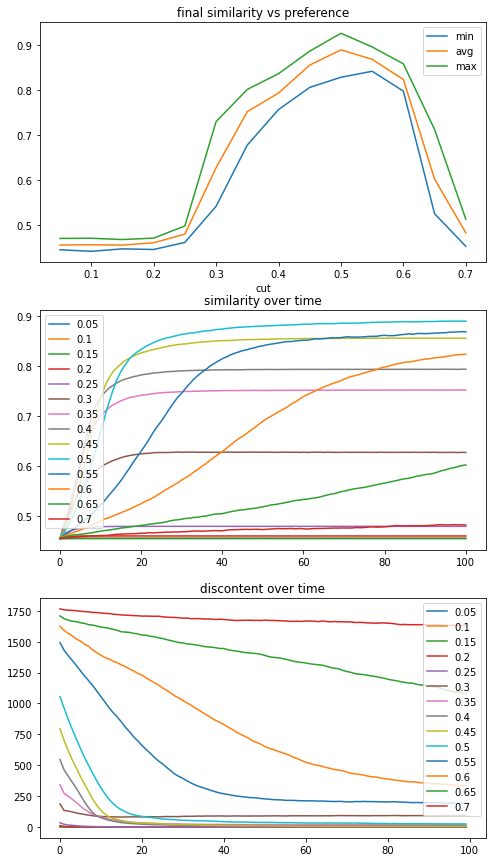

In [48]:
fig, axes = plt.subplots(3,1, figsize=(8,15))
df.set_index('cut').plot(ax=axes[0], title='final similarity vs preference')
all_similarities_over_time.plot(ax=axes[1], title = 'similarity over time')
all_discontents_over_time.plot(ax=axes[2], title='discontent over time')


In [42]:
df.to_csv('segregation_figure4.csv', index=False)
all_similarities_over_time.to_csv('segregation_figure5.csv', index=False)
all_discontents_over_time.to_csv('segregation_figure6.csv', index=False)

# CREATE AN ANIMATION TO SHOW THE EVOLUTION OF THE CITY OVER TIME

In [ ]:

# SIMULATION
# init a random distribution of B, W, Es across a 2D grid
radius = 2
cutpoint = 0.35

for cut in [0.4]:
    print('working on {}'.format(cut))

    # initialize
    np.random.seed(314159)
    random.seed(2718)
    brooklyn = np.random.choice(a=['B', 'W', 'E'], size=(32,16), p=[.48, .50, .02])
    #all_spaces = [(i,j) for j in range(brooklyn.shape[0]) for i in range(brooklyn.shape[1])]
    
    # run simulation
    # (return the final avg similarity at the end and also a list with grids at each iteration of the simulation)
    avg_similarity, simulations = simulate(grid=brooklyn, radius=radius, cutpoint=cut, num_iterations=60, verbose=2)

    # create a formatted image for each iteration of the simulation
    color_scheme = {'B': [38,131,131], 'W': [38, 190, 129], 'E': [0,0,0]}
    gif = []
    for i, sim in enumerate(simulations):

        


        if i == 0:
            this_similarity = np.mean(calc_avg_similarity(sim))
            this_text = 'INITIAL STATE: Populations start mixed'.format(this_similarity)
            image = build_image(grid=sim, conversion_map=color_scheme, square_size=20, white_space_height=75, text=this_text, text_position=(10,330))

            gif.append(Image.fromarray(image, 'RGB'))
            gif.append(Image.fromarray(image, 'RGB'))
            gif.append(Image.fromarray(image, 'RGB'))
            gif.append(Image.fromarray(image, 'RGB'))


        if i % 5 == 0:
            this_similarity = np.mean(calc_avg_similarity(sim))
            this_text = 'Iteration {}: Avg Similarity {:.2f}'.format(i, this_similarity)
            image = build_image(grid=sim, conversion_map=color_scheme, square_size=20, white_space_height=75, text=this_text, text_position=(10,330))

            gif.append(Image.fromarray(image, 'RGB'))



        if i == 60:

            this_text = 'FINAL STATE: Populations end up segregated'.format(this_similarity)
            image = build_image(grid=sim, conversion_map=color_scheme, square_size=20, white_space_height=75, text=this_text, text_position=(10,330))

            gif.append(Image.fromarray(image, 'RGB'))
            gif.append(Image.fromarray(image, 'RGB'))
            gif.append(Image.fromarray(image, 'RGB'))
            gif.append(Image.fromarray(image, 'RGB'))


    # https://pomain.medium.com/how-to-build-gif-video-from-images-with-python-pillow-opencv-c3126ce89ca8
    gif[0].save('test_gif.gif', save_all=True, optimize=True, append_images=gif[1:], loop=0, duration=600)


print('done')

In [49]:
img = Image.fromarray(temp, 'RGB')
#img.save('test_image.png', "PNG")
img


AttributeError: 'list' object has no attribute '__array_interface__'

In [ ]:


temp = build_image(grid=simulations[0], conversion_map={'B': [38,131,131], 'W': [38, 190, 129], 'E': [0,0,0]}, square_size=20, white_space_height=75, text = 'Iteration 1: Avg Similarity 0.34', text_position=(10,330))

img = Image.fromarray(temp, 'RGB')
#img.save('test_image.png', "PNG")
img


In [ ]:
temp = build_image(grid=simulations[-1], conversion_map={'B': [38,131,131], 'W': [38, 190, 129], 'E': [128,128,128]}, square_size=20, white_space_height=75, text = 'Iteration 1: Avg Similarity 0.34', text_position=(10,330))

img = Image.fromarray(temp, 'RGB')
#img.save('test_image.png', "PNG")
img

In [ ]:
from PIL import Image


w, h = 512, 512

# make a numpy array 
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left

# convert numpy array to pillow Image
img = Image.fromarray(data, 'RGB')


plt.imshow(img)
plt.show()

In [ ]:
import plotly.express as px
import numpy as np
img_rgb = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    [[0, 255, 0], [0, 0, 255], [255, 0, 0]]
                   ], dtype=np.uint8)
fig = px.imshow(img_rgb)
fig.show()

In [ ]:
img = np.arange(15**2).reshape((15, 15))
fig = px.imshow(img)
fig.show()

In [ ]:
data = np.zeros(shape=(500, 750,3), dtype=np.uint8)
data[:,:,0] = 255
data[:,:,1] = 0
data[:,:,2] = 0

print(data[10,252])

img = Image.fromarray(data, 'RGB')
img

In [ ]:

# init a black background
w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)

# add colors
data[0:256, 0:256] = [38, 190, 129] # upper left quadrant green
data[256:, 256:] = [38,170,193] # lower right quadrant blue

img = Image.fromarray(data, 'RGB')
plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
data = np.zeros((h, w, 3), dtype=np.uint8)

# set the entire background to green
data[:, :] = [38, 190, 129] 

# randomly make 40% of the space dark green
for _ in range(int(w * h * .40)):

    # get a x,y random spot in the space
    i = np.random.choice(range(h))
    j = np.random.choice(range(w))

    # set to dark green
    data[i,j] = [38,131,131]

img = Image.fromarray(data, 'RGB')
# plt.imshow(img)
# plt.show()
img

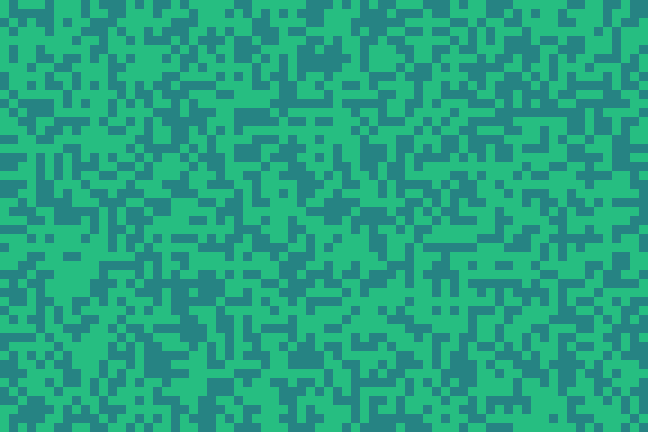

In [50]:
# MAKE A GRID OF SQUARES, WHERE EACH SQUARE IS 8 PIXELS ACROSS

import numpy as np

gif = []
images = []

start = time.time()
w, h = 72, 48
size = 9
w_, h_ = w*size, h*size

# init grid
data = np.zeros((h_, w_, 3), dtype=np.uint8)
data[:, :] = [38, 190, 129] 

# randomly place 
picked = []
for _ in range(int(w*h*0.45)):
    
    search = True
    while search:
        i = np.random.choice(range(h))
        j = np.random.choice(range(w))
        if not (i,j) in picked:
            search = False
            picked.append((i,j))
             
    for _i in range(size):
        for _j in range(size):
            data[i*size + _i,j*size + _j] = [38,131,131]

    gif.append(Image.fromarray(data, 'RGB'))
    images.append(data)

# for _ in range(int(w*h*0.05)):
#     i = np.random.choice(range(h))
#     j = np.random.choice(range(w))

#     for _i in range(size):
#         for _j in range(size):
#             data[i*size + _i,j*size + _j] = [0,0,0]


img = Image.fromarray(data, 'RGB')
img

In [ ]:
# https://pomain.medium.com/how-to-build-gif-video-from-images-with-python-pillow-opencv-c3126ce89ca8
gif[0].save('test_gif.gif', save_all=True, optimize=True, append_images=gif[1:], loop=0, duration=1)

In [ ]:
video = cv2.VideoWriter("test.avi", cv2.VideoWriter_fourcc(*'XVID'), 24, (w,h))
for image in images:
    video.write(image)

print('done')